In [67]:
# !pip install numpy
# !pip install scipy
# !pip install random
# !pip install pandas
# !pip install math
# !pip install os
# !pip install scikit-learn
# !pip install torch
# !pip install scikit-image

In [68]:
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import torch, math
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce
import os
import random
from skimage import io, measure

Setting the seed of GPU

In [69]:
# def seed_torch(seed = 123):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

# seed_torch()

# 1. Feature extraction network

In [70]:
class FeatNet(nn.Module):
    def __init__(self):
        super(FeatNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.bn1_1 = nn.BatchNorm2d(16)

        self.conv1_1 = nn.Conv2d(16, 16, 3, 1, 1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, 1)
        self.bn1_2 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 1 ,2, 1)

        self.conv2_1 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.bn2_2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 1, 2, 1)

        self.conv3_1 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.bn3_2 = nn.BatchNorm2d(64)

        # Feature fusion
        self.conv_fusion1 = nn.Conv2d(16, 64, 1, 4, 2)
        self.conv_fusion2 = nn.Conv2d(32, 64, 1, 2, 1)

    def forward(self, x):

        x1 = self.conv1(x)
        x = F.relu(self.bn1_1(self.conv1_1(x1)))
        x_1 = F.relu(self.bn1_2(self.conv1_2(x)))
        x = x1 + x_1
        x2 = self.conv2(x)
        x = F.relu(self.bn2_1(self.conv2_1(x2)))
        x_2 = F.relu(self.bn2_2(self.conv2_2(x)))
        x = x2 + x_2
        x3 = self.conv3(x)
        x = F.relu(self.bn3_1(self.conv3_1(x3)))
        x_3 = F.relu(self.bn3_2(self.conv3_2(x)))
        return x_1, x_2, x_3

class FeatFuse(nn.Module):
    def __init__(self):
        super(FeatFuse, self).__init__()

        self.conv_fusion1 = nn.Conv2d(16, 64, 1, 4, 3)
        self.conv_fusion2 = nn.Conv2d(32, 64, 1, 2, 1)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 64*3)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x1, x2, x3):

        batch_size = x1.size(0)
        out_channels = x3.size(1)
        x1 = self.conv_fusion1(x1)
        x2 = self.conv_fusion2(x2)
        output = []
        output.append(x1)
        output.append(x2)
        output.append(x3)
        x = x1 + x2 + x3

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        a_b = x.reshape(batch_size, 3, out_channels, -1)
        a_b = self.softmax(a_b)
        #the part of selection
        a_b = list(a_b.chunk(3, dim=1))#split to a and b
        a_b = list(map(lambda x:x.reshape(batch_size, out_channels, 1, 1), a_b))
        V = list(map(lambda x,y:x*y, output, a_b))
        V = reduce(lambda x,y:x+y, V)
        return V

# 2. The proposed SAFNet

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.featnet = FeatNet()
        self.featfuse = FeatFuse()
        self.featnet1 = FeatNet()
        self.featfuse1 = FeatFuse()
        #self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 2)

        self.global_pool1 = nn.AdaptiveAvgPool2d(1)
        self.global_pool2 = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(64, 2)
        self.fc2 = nn.Linear(64, 2)


    def forward(self, x, y):

        x1_1, x1_2, x1_3 = self.featnet(x)
        x2_1, x2_2, x2_3 = self.featnet1(y)

        feat_11 = self.featfuse(x1_1, x1_2, x1_3)
        feat_22 = self.featfuse1(x2_1, x2_2, x2_3)
        feat_1 = self.global_pool1(feat_11)
        feat_2 = self.global_pool2(feat_22)
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        feat_1 = self.fc1(feat_1)
        feat_2 = self.fc2(feat_2)

        feature_corr = self.xcorr_depthwise(feat_11, feat_22)
        feat = feature_corr.view(feature_corr.size(0), -1)
        #feat = global_pool(feature_corr)
        feat = self.fc(feat)
        return feat_1, feat_2, feat

    def xcorr_depthwise(self, x, kernel):

        batch = kernel.size(0)
        channel = kernel.size(1)
        x = x.view(1, batch*channel, x.size(2), x.size(3))
        kernel = kernel.view(batch*channel, 1, kernel.size(2), kernel.size(3))
        out = F.conv2d(x, kernel, groups=batch*channel)
        out = out.view(batch, channel, out.size(2), out.size(3))
        return out

In [72]:
# from google.colab import drive
# drive.mount('/content/drive')

# 3. Data processing function

In [73]:
def addZeroPadding(X, margin=2):
    newX = np.zeros((
        X.shape[0] + 2 * margin,
        X.shape[1] + 2 * margin,
        X.shape[2]
              ))
    newX[margin:X.shape[0]+margin, margin:X.shape[1]+margin, :] = X
    return newX

def createImgCube(X ,gt ,pos:list ,windowSize=25):
    margin = (windowSize-1)//2
    zeroPaddingX = addZeroPadding(X, margin=margin)
    dataPatches = np.zeros((pos.__len__(), windowSize, windowSize, X.shape[2]))
    if( pos[-1][1]+1 != X.shape[1] ):
        nextPos = (pos[-1][0] ,pos[-1][1]+1)
    elif( pos[-1][0]+1 != X.shape[0] ):
        nextPos = (pos[-1][0]+1 ,0)
    else:
        nextPos = (0,0)
    return np.array([zeroPaddingX[i:i+windowSize, j:j+windowSize, :] for i,j in pos ]),\
    np.array([gt[i,j] for i,j in pos]) ,\
    nextPos

def createPos(shape:tuple, pos:tuple, num:int):
    if (pos[0]+1)*(pos[1]+1)+num >shape[0]*shape[1]:
        num = shape[0]*shape[1]-( (pos[0])*shape[1] + pos[1] )
    return [(pos[0]+(pos[1]+i)//shape[1] , (pos[1]+i)%shape[1] ) for i in range(num) ]

def createPosWithoutZero(hsi, gt):
    print(np.unique(gt))
    mask = gt > 0
    return [(i,j) for i , row  in enumerate(mask) for j , row_element in enumerate(row) if row_element]

def splitTrainTestSet(X, gt, testRatio, randomState=111):

    X_train, X_test, gt_train, gt_test = train_test_split(X, gt, test_size=testRatio, random_state=randomState, stratify=gt)
    return X_train, X_test, gt_train, gt_test

def createImgPatch(lidar, pos:list, windowSize=25):

    margin = (windowSize-1)//2
    zeroPaddingLidar = np.zeros((
      lidar.shape[0] + 2 * margin,
      lidar.shape[1] + 2 * margin
            ))
    zeroPaddingLidar[margin:lidar.shape[0]+margin, margin:lidar.shape[1]+margin] = lidar
    return np.array([zeroPaddingLidar[i:i+windowSize, j:j+windowSize] for i,j in pos ])

def minmax_normalize(array):
    amin = np.min(array)
    amax = np.max(array)
    return (array - amin) / (amax - amin)
def postprocess(res):
    res_new = res
    res = measure.label(res, connectivity=2)
    num = res.max()
    for i in range(1, num+1):
        idy, idx = np.where(res==i)
        if len(idy) <= 20:
            res_new[idy, idx] = 0
    return res_new

# 4. Create dataloader

In [81]:
from PIL import Image
import numpy as np

windowSize = 7 # patch size
class_num = 2
testRatio = 0.2 # the ratio of Validation set
trainRatio = 0.9 # the ratio of Training set selected from preclassification

# data_path = './input_data/'
image_path_gt = "ottawa_gt.bmp"
im_gt = Image.open(image_path_gt)
im_gt = im_gt.convert('L')
im_gt = np.array(im_gt)
im_gt[im_gt == 255] = 1

data_traingt = im_gt
data_testgt = im_gt

image_path1 = "ottawa_1.bmp"
im1 = Image.open(image_path1)
im1_gray = im1.convert('L')
im1_array = np.array(im1_gray)
im1_array[im1_array == 255] = 1
# Reshape the NumPy array to add an extra dimension
im1 = im1_array.reshape(im1_array.shape[0], im1_array.shape[1], 1)

print(im1.shape)

image_path2 = "ottawa_2.bmp"
im2 = Image.open(image_path2)
im2_gray = im2.convert('L')
im2_array = np.array(im2_gray)
im2_array[im2_array == 255] = 1
# Reshape the NumPy array to add an extra dimension
im2 = im2_array.reshape(im2_array.shape[0], im2_array.shape[1], 1)


data_traingt = np.array(im_gt)
data_testgt = np.array(im_gt)
# print("train shape: ", data_traingt.shape)

# print (im1.size)
height , width, c = im1.shape

# All pseudo-label set
train_1, labels ,_ = createImgCube(im1, data_traingt, createPosWithoutZero(im1, data_traingt), windowSize=windowSize)
train_2, _ ,_ = createImgCube(im2, data_traingt, createPosWithoutZero(im2, data_traingt), windowSize=windowSize)

# training set selected from pseudo-label set
train_1, _, train_labels, _ = splitTrainTestSet(train_1, labels, trainRatio, randomState=111)
train_2, _, _, _ = splitTrainTestSet(train_2, labels, trainRatio, randomState=111)

# data augmentation if need
Xh = []
Xl = []
y = []
for i in range(train_1.shape[0]):
    Xh.append(train_1[i])
    Xl.append(train_2[i])

    noise = np.random.normal(0.0, 0.01, size=train_1[0].shape)
    noise2 = np.random.normal(0.0, 0.01, size=train_2[0].shape)
    Xh.append(np.flip(train_1[i] + noise, axis=1))
    Xl.append(np.flip(train_2[i] + noise2, axis=1))

    k = np.random.randint(4)
    Xh.append(np.rot90(train_1[i], k=k))
    Xl.append(np.rot90(train_2[i], k=k))

    y.append(train_labels[i])
    y.append(train_labels[i])
    y.append(train_labels[i])

labels = np.asarray(y, dtype=np.int8)
train_1 = np.asarray(Xh, dtype=np.float32)
train_2 = np.asarray(Xl,dtype=np.float32)
train_1 = torch.from_numpy(train_1.transpose(0,3,1,2)).float()
train_2 = torch.from_numpy(train_2.transpose(0,3,1,2)).float()

# Select a partial validation set from the training set
X_train, X_val, train_labels, val_labels = splitTrainTestSet(train_1, labels, testRatio, randomState=111)
X_train_2, X_val_2, _, _ = splitTrainTestSet(train_2, labels, testRatio, randomState=111)

# testing set
X_test, test_labels ,_ = createImgCube(im1, data_traingt, createPosWithoutZero(im1, data_testgt), windowSize=windowSize)
X_test_2, _ ,_ = createImgCube(im2, data_traingt, createPosWithoutZero(im2, data_testgt), windowSize=windowSize)
X_test = torch.from_numpy(X_test.transpose(0,3,1,2)).float()
X_test_2 = torch.from_numpy(X_test_2.transpose(0,3,1,2)).float()

print (X_train.shape)
print (X_val.shape)
print (X_test.shape)
print("Creating dataloader")

""" Training dataset"""
class TrainDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = train_labels.shape[0]
        self.hsi = torch.FloatTensor(X_train)
        self.lidar = torch.FloatTensor(X_train_2)
        self.labels = torch.LongTensor(train_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = test_labels.shape[0]
        self.hsi = torch.FloatTensor(X_test)
        self.lidar = torch.FloatTensor(X_test_2)
        self.labels = torch.LongTensor(test_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len
""" Validation dataset"""
class ValDS(torch.utils.data.Dataset):
    def __init__(self):
        self.len = val_labels.shape[0]
        self.hsi = torch.FloatTensor(X_val)
        self.lidar = torch.FloatTensor(X_val_2)
        self.labels = torch.LongTensor(val_labels - 1)
    def __getitem__(self, index):
        return self.hsi[index], self.lidar[index], self.labels[index]
    def __len__(self):
        return self.len


# generate trainloader and valloader
trainset = TrainDS()
testset  = TestDS()
valset = ValDS()
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = 128, shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(dataset = testset, batch_size =128, shuffle = False, num_workers = 0)
val_loader = torch.utils.data.DataLoader(dataset = valset, batch_size =128, shuffle = False, num_workers = 0)

(350, 290, 1)
[0 1]
[0 1]
[0 1]
[0 1]
torch.Size([3849, 1, 7, 7])
torch.Size([963, 1, 7, 7])
torch.Size([16049, 1, 7, 7])
Creating dataloader


# 6. Running

In [75]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2)+(1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

def calc_loss(x1, x2, outputs, labels, alpha):

    criterion = nn.CrossEntropyLoss()
    loss1 = criterion(outputs, labels)

    contrastive = ContrastiveLoss()
    loss2 = contrastive(x1, x2, labels)

    loss_sum = loss1 + alpha* loss2
    return loss_sum

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for i, (inputs_1, inputs_2, labels) in enumerate(train_loader):

        inputs_1, inputs_2 = inputs_1.to(device), inputs_2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        feat_1, feat_2, outputs = model(inputs_1, inputs_2)
        loss = calc_loss(feat_1, feat_2, outputs, labels, alpha = 1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

def test(model, device, test_loader):
    model.eval()
    predicted_changes = []
    test_labels_list = []
    for inputs_1, inputs_2, labels in test_loader:
        inputs_1, inputs_2 = inputs_1.to(device), inputs_2.to(device)
        _, _, outputs = model(inputs_1, inputs_2)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        predicted_changes.extend(outputs)
        test_labels_list.extend(labels.numpy())

    predicted_changes = np.array(predicted_changes)
    test_labels = np.array(test_labels_list)
    # print("predicted changes", len(predicted_changes), test_labels.shape, predicted_changes)

    correct_predictions = (predicted_changes == test_labels)
    accuracy = np.mean(correct_predictions) * 100
    print('Accuracy: %.2f' % accuracy)

    return accuracy, predicted_changes

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

num_epochs = 50
lr = 0.001
momentum = 0.9
betas = (0.9, 0.999)

params_to_update = list(model.parameters())

# optimizer = torch.optim.Adam(params_to_update, lr=lr, betas=betas)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum,weight_decay=0.0005)

best_acc = 0
for epoch in range(num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    acc = test(model, device, val_loader)[0]
    if acc >= best_acc:
        best_acc = acc
        print("Save model!")
        torch.save(model.state_dict(),'model.pth')

[Epoch: 1]   [loss avg: 36.3798]   [current loss: 0.0744]
Accuracy: 100.00
Save model!
[Epoch: 2]   [loss avg: 0.6286]   [current loss: 0.0331]
Accuracy: 100.00
Save model!
[Epoch: 3]   [loss avg: 0.1554]   [current loss: 0.0114]
Accuracy: 100.00
Save model!
[Epoch: 4]   [loss avg: 0.0703]   [current loss: 0.0054]
Accuracy: 100.00
Save model!
[Epoch: 5]   [loss avg: 0.0400]   [current loss: 0.0026]
Accuracy: 100.00
Save model!
[Epoch: 6]   [loss avg: 0.0258]   [current loss: 0.0044]
Accuracy: 100.00
Save model!
[Epoch: 7]   [loss avg: 0.0177]   [current loss: 0.0023]
Accuracy: 100.00
Save model!
[Epoch: 8]   [loss avg: 0.0129]   [current loss: 0.0025]
Accuracy: 100.00
Save model!
[Epoch: 9]   [loss avg: 0.0096]   [current loss: 0.0011]
Accuracy: 100.00
Save model!
[Epoch: 10]   [loss avg: 0.0075]   [current loss: 0.0010]
Accuracy: 100.00
Save model!
[Epoch: 11]   [loss avg: 0.0063]   [current loss: 0.0031]
Accuracy: 100.00
Save model!
[Epoch: 12]   [loss avg: 0.0050]   [current loss: 0

# 7. Record the final change map

[0 1]
Accuracy: 100.00
The final accuracy is  100.0


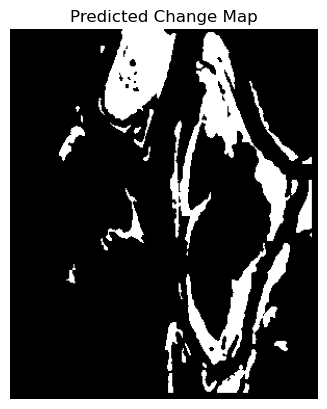

In [80]:
model = Net().eval().to(device)
model.load_state_dict(torch.load('./model.pth'))
changed_pixels_positions = createPosWithoutZero(im1, data_testgt)

acc,predicted_changes = test(model, device, test_loader)
# predicted_changes = predicted_changes[:len(changed_pixels_positions)]
print ('The final accuracy is ', acc)
# print("len of changed_pixels_positions and predicted_changes ", len(changed_pixels_positions), len(predicted_changes))

binary_image = np.full_like(im1, 0, dtype=np.uint8)
# print("change pixels: ", predicted_changes.shape)
# print(predicted_changes.shape)
# Map predicted changes to the corresponding indices in changed_pixels_positions
for idx, value in enumerate(predicted_changes):
    # print(idx, value)
    if value == 1:
        y, x = changed_pixels_positions[idx]
        binary_image[y, x] = 0  # Set as black for unchanged pixels
    elif value == 0:
        y, x = changed_pixels_positions[idx]
        binary_image[y, x] = 255  # Set as white for changed pixels

import matplotlib.pyplot as plt
# Visualize the binary image
plt.imshow(binary_image[:, :, 0], cmap='gray')
plt.axis('off')
plt.title('Predicted Change Map')
plt.savefig("Ottawa_Benchmark_100%.png")
plt.show()

In [78]:
# model = Net().eval().to(device)
# model.load_state_dict(torch.load('./model.pth'))
# acc = test(model, device, test_loader)
# print ('The final accuracy is ', acc)
# margin = (windowSize-1)//2
# im1 = addZeroPadding(im1, margin=margin)
# im2 = addZeroPadding(im2, margin=margin)

# outputs = np.zeros((height, width))
# for i in range(height):
#     for j in range(width):
#     # if preclassify_lab[i, j]!= 1.5:
#     #   outputs[i, j] = preclassify_lab[i, j]

#     # else:
#         patch1 = im1[i:i+windowSize, j:j+windowSize, :]
#         patch1 = patch1.reshape(1, patch1.shape[0], patch1.shape[1], patch1.shape[2])
#         X_test_image = torch.FloatTensor(patch1.transpose(0, 3, 1, 2)).to(device)

#         patch2 = im2[i:i+windowSize, j:j+windowSize, :]
#         patch2 = patch2.reshape(1, patch2.shape[0], patch2.shape[1], patch2.shape[2])
#         X_test_image1 = torch.FloatTensor(patch2.transpose(0, 3, 1, 2)).to(device)

#         _, _, prediction = model(X_test_image, X_test_image1)
#         prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
#         outputs[i][j] = prediction
#     if i % 20 == 0:
#         print('... ... row ', i, ' handling ... ...')
# # postprocessing if need
# outputs = postprocess(outputs)

# sio.savemat('result.mat', {'output': outputs})
# print('ALL Finish!!')

Accuracy: 100.00
The final accuracy is  (100.0, array([0, 0, 0, ..., 0, 0, 0]))


/tmp/ipykernel_2287613/1767960441.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction


... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...
... ... row  160  handling ... ...
... ... row  180  handling ... ...
... ... row  200  handling ... ...
... ... row  220  handling ... ...
... ... row  240  handling ... ...
... ... row  260  handling ... ...
... ... row  280  handling ... ...
... ... row  300  handling ... ...
... ... row  320  handling ... ...
... ... row  340  handling ... ...
ALL Finish!!
